# Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import warnings
import tensorflow.keras.backend as K
warnings.filterwarnings("ignore")
#K.tensorflow_backend._get_available_gpus()

# Reading Data:

In [2]:
train_df = pd.read_csv('train.csv', index_col='id', engine='python')
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [3]:
test_df = pd.read_csv('test.csv', index_col='id', engine='python')
test_df.head()

,comment_text
id,
7097320,[ Integrity means that you pay your debts.]\n\...
7097321,This is malfeasance by the Administrator and t...
7097322,@Rmiller101 - Spoken like a true elitist. But ...
7097323,"Paul: Thank you for your kind words. I do, in..."
7097324,Sorry you missed high school. Eisenhower sent ...


In [4]:
train_df.describe()

,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,...,parent_id,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,405130.000000,...,1.026228e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,0.034393,...,3.722687e+06,2.813597e+05,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01,6.605974e-03,1.439019e+00,8.784694e+00
std,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,0.167900,...,2.450261e+06,1.039293e+05,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00,4.529782e-02,1.787041e+01,4.350086e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,6.100600e+04,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,7.960188e+05,1.601200e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.222993e+06,3.321260e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
75%,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,5.775758e+06,3.662370e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,6.333965e+06,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03


Looking at count values of asian,atheist etc columns we see that there are a lot of Null values present, but this is OK as we are only supposed to use 'comment_text' column so dealing with these is not really necessary here

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1804874 entries, 59848 to 6334010
Data columns (total 44 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   target                               float64
 1   comment_text                         object 
 2   severe_toxicity                      float64
 3   obscene                              float64
 4   identity_attack                      float64
 5   insult                               float64
 6   threat                               float64
 7   asian                                float64
 8   atheist                              float64
 9   bisexual                             float64
 10  black                                float64
 11  buddhist                             float64
 12  christian                            float64
 13  female                               float64
 14  heterosexual                         float64
 15  hindu                       

In [6]:
train_df.isnull().sum()

target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male                                   1399744
muslim       

No Null values for target and comment_text columns

In [7]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (1804874, 44) (97320, 1)


# Exploratory Data Analysis:
1. Target Feature:

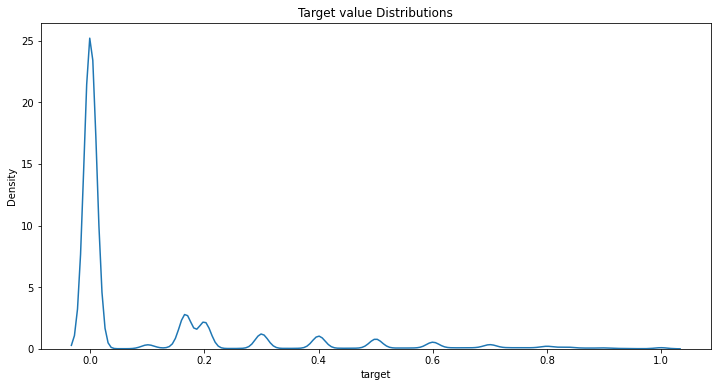

In [8]:
plt.figure(figsize=(12,6))
plt.title("Target value Distributions")
sns.distplot(train_df['target'], kde=True, hist=False, bins=240, label='target')
plt.show()

We see that most of the comments present in the dataset are actually non-toxic (<0.5) and only a few of them are actually toxic (>0.5)

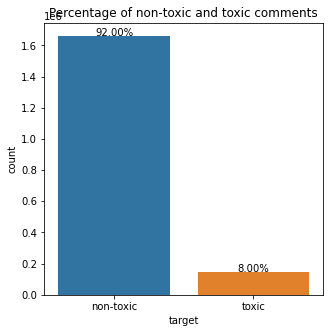

In [9]:
# If toxicity rating < 0.5 then the comment is non-toxic else it is toxic.
# Get toxic and non-toxic comments.
temp = train_df['target'].apply(lambda x: "non-toxic" if x < 0.5 else "toxic")

# Plot the number and percentage of toxic and non-toxic comments.
fig, ax = plt.subplots(1,1,figsize=(5,5))
total = float(len(temp))

# Plot the count plot.
cntplot = sns.countplot(temp)
cntplot.set_title('Percentage of non-toxic and toxic comments')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

# 2. Toxicity Subtype Features:
1.severe_toxicity
2.obscene
3.threat
4.insult
5.identity_attack

In [10]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit according to my needs
def plot_features_distribution(features, title, data):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        sns.distplot(data[feature],kde=True,hist=False, bins=240, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

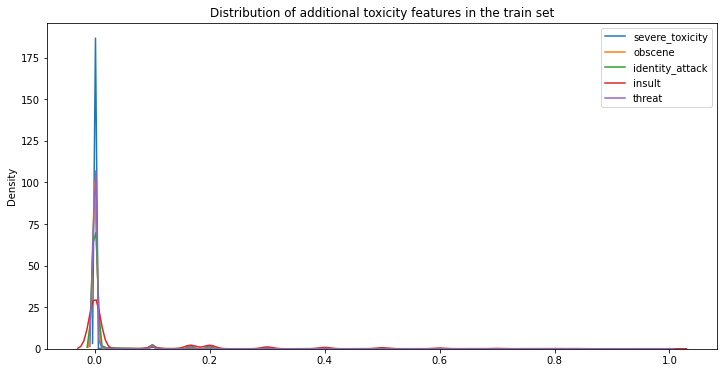

In [11]:
features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
plot_features_distribution(features, "Distribution of additional toxicity features in the train set", train_df)

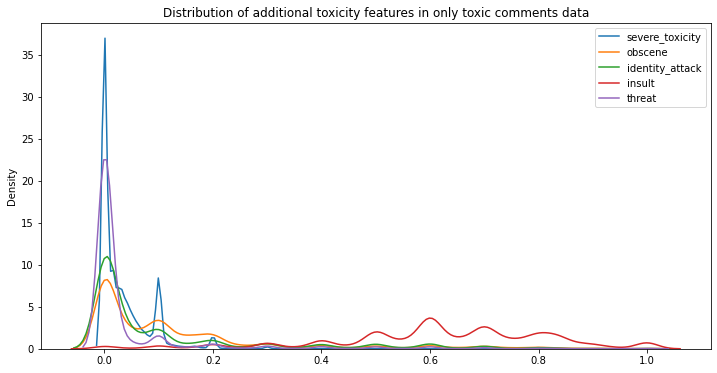

In [12]:
# Looking at the distribution of additional toxicity features on the comments that are actually considered toxic:
temp = train_df[train_df['target'] > 0.5]
plot_features_distribution(features, "Distribution of additional toxicity features in only toxic comments data", temp)

We see that for toxic comments data, there are more insulting comments as compared to obscene comments

In [13]:
# Getting the count of additonal toxicity features in toxic comments data(temp):
def get_comment_nature(row):
    # Extract type of toxic comment
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

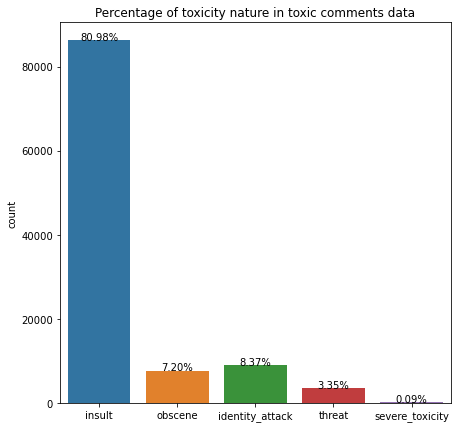

In [14]:
x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment
fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of toxicity nature in toxic comments data')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

In our train dataset only 8% of the data was toxic. Out of that 8%, 81% of the toxic comments made are insults, 8.37% are identity attacks, 7.20% are obscene, 3.35% are threats and a very small amount of toxic comments are severly toxic.

# 3. Identity Attributes:
Sensitive topics:

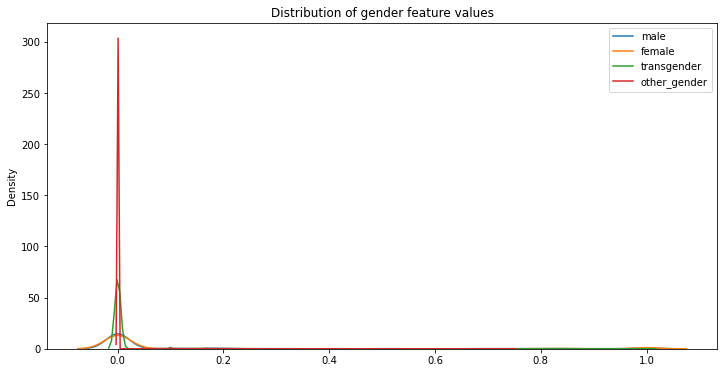

In [15]:
temp = train_df.dropna(axis = 0, how = 'any')
features = ['male', 'female', 'transgender', 'other_gender']
plot_features_distribution(features, "Distribution of gender feature values", temp)

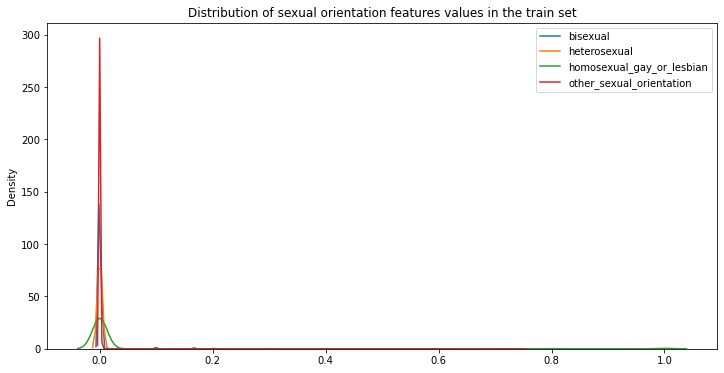

In [16]:
features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
plot_features_distribution(features, "Distribution of sexual orientation features values in the train set", temp)

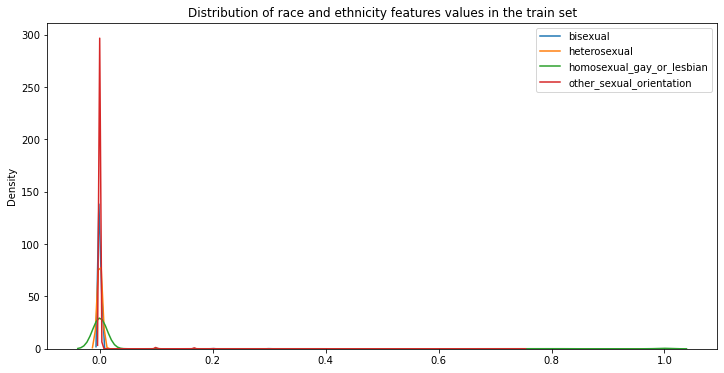

In [17]:
eatures = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
plot_features_distribution(features, "Distribution of race and ethnicity features values in the train set", temp)

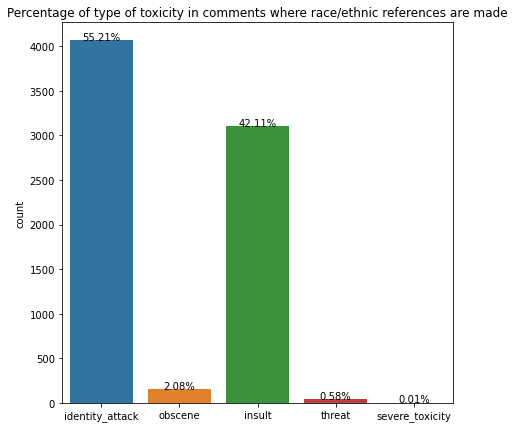

In [18]:
# Get data where race/ethnic references are made.
cond = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where race/ethnic references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

We see that the toxic comments involving words like black, asian etc. are mainly used for identity attacks or insults.

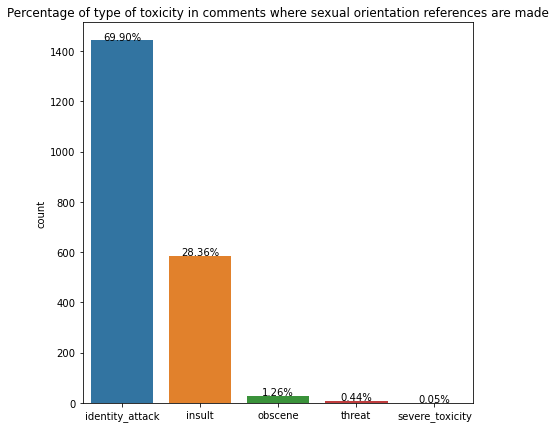

In [19]:
# Get data where race/ethnic references are made.
cond = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where sexual orientation references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

We see from the plot that the toxic comments where sexual orientation references are made are mostly used for identity attacks.

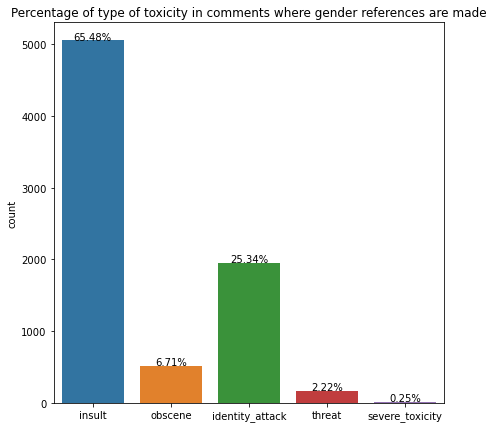

In [20]:
# Get data where race/ethnic references are made.
cond = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
temp = train_df[cond] # Get data where race/ethnic references are made.
temp = temp[temp['target'] > 0.5] # Extract only toxic comments.

x = temp.apply(get_comment_nature, axis=1) # Get nature of each toxic comment

fig, ax = plt.subplots(1,1,figsize=(7,7))
total = float(len(x))

# Plot the count plot.
cntplot = sns.countplot(x)
cntplot.set_title('Percentage of type of toxicity in comments where gender references are made')

# Get the height and calculate percentage then display it the plot itself.
for p in ax.patches:
    # Get height.
    height = p.get_height()
    # Plot at appropriate position.
    ax.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')
    
plt.show()

From the plot we see that the toxic comments which involve words like male, female etc are insults.

# 4. Features generated by users feedback:

In [21]:
# Code from: https://www.kaggle.com/gpreda/jigsaw-eda
# Modified a bit
def plot_count(feature, title, data, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(data))
    g = sns.countplot(data[feature], order = data[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

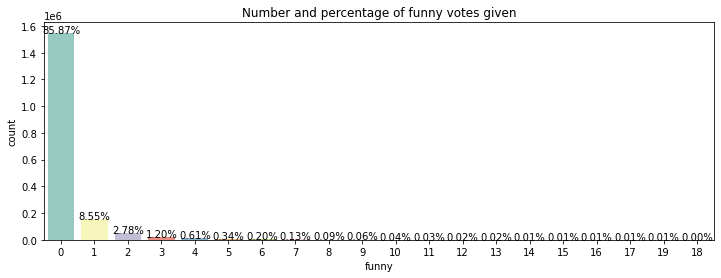

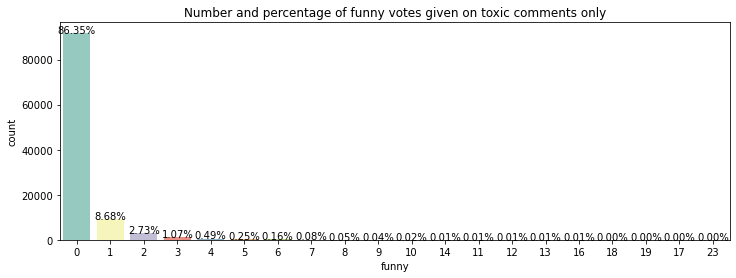

In [22]:
plot_count('funny','funny votes given', train_df, 3)
plot_count('funny', 'funny votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

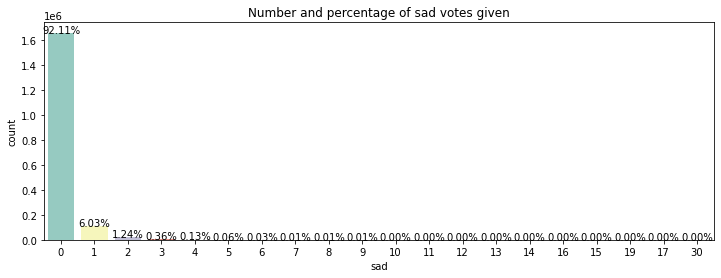

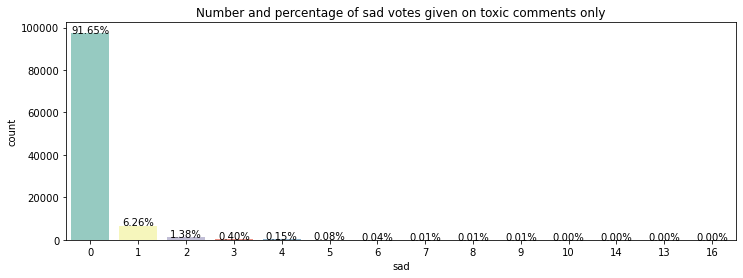

In [23]:
plot_count('sad','sad votes given', train_df, 3)
plot_count('sad', 'sad votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

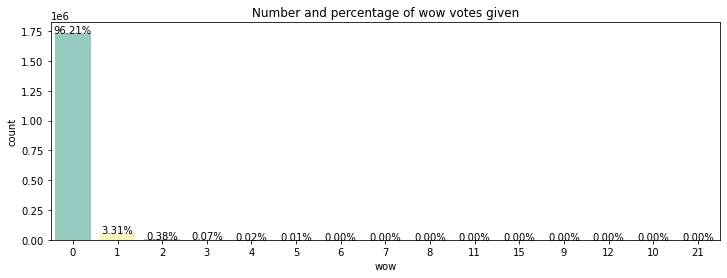

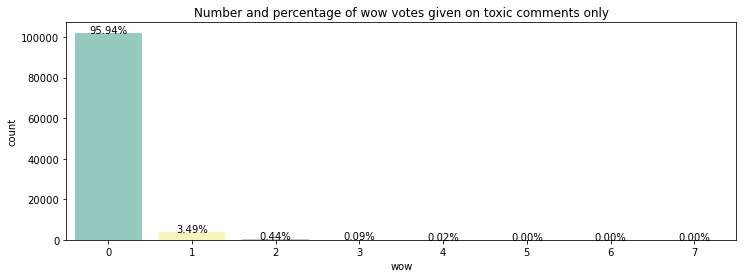

In [24]:
plot_count('wow','wow votes given', train_df, 3)
plot_count('wow', 'wow votes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

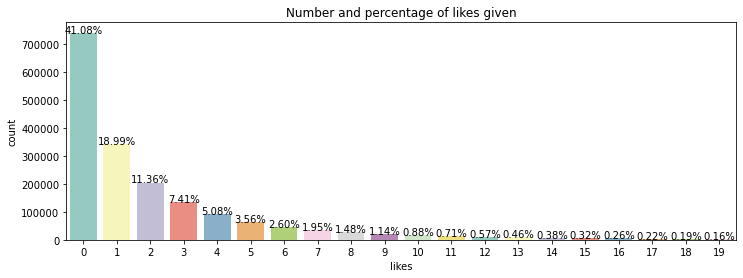

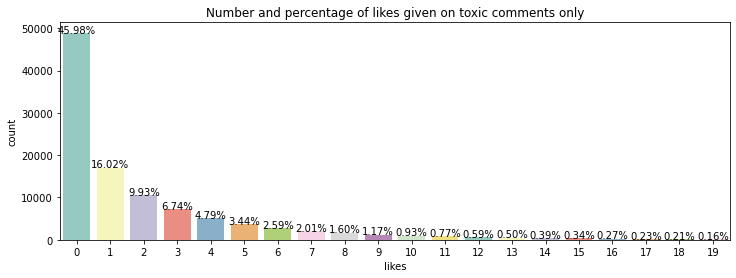

In [25]:
plot_count('likes','likes given', train_df, 3)
plot_count('likes', 'likes given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

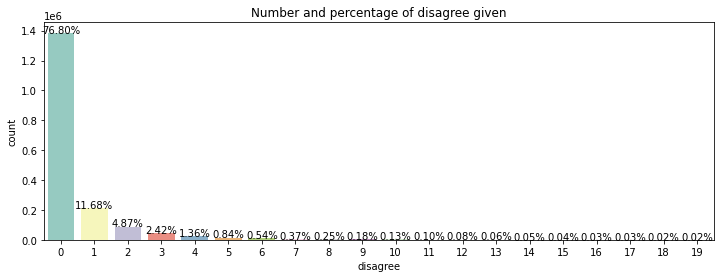

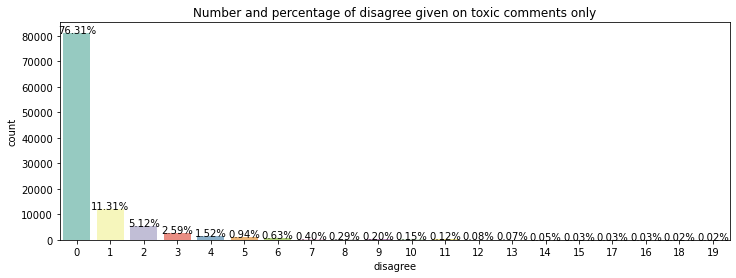

In [26]:
plot_count('disagree','disagree given', train_df, 3)
plot_count('disagree', 'disagree given on toxic comments only', train_df[train_df['target'] > 0.5], 3)

# 5. Comments_text Feature:

In [27]:
# Code From: https://www.kaggle.com/gpreda/jigsaw-eda
stpwrds = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stpwrds,
        max_words=50,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

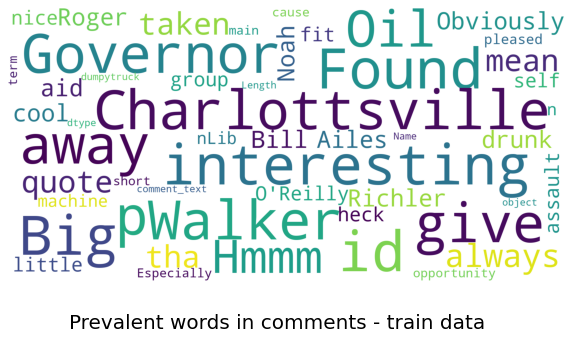

In [28]:
show_wordcloud(train_df['comment_text'].sample(20000), title = 'Prevalent words in comments - train data')

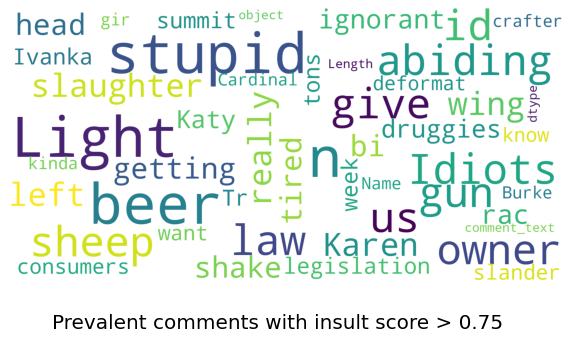

In [29]:
show_wordcloud(train_df.loc[train_df['insult'] > 0.75]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score > 0.75')

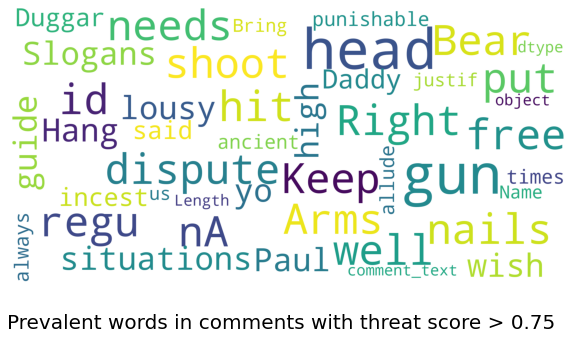

In [30]:
show_wordcloud(train_df.loc[train_df['threat'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with threat score > 0.75')

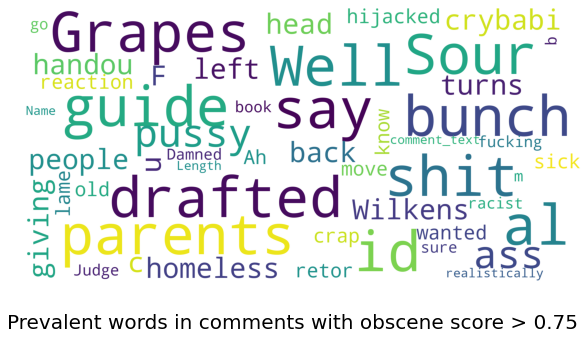

In [31]:
show_wordcloud(train_df.loc[train_df['obscene'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with obscene score > 0.75')

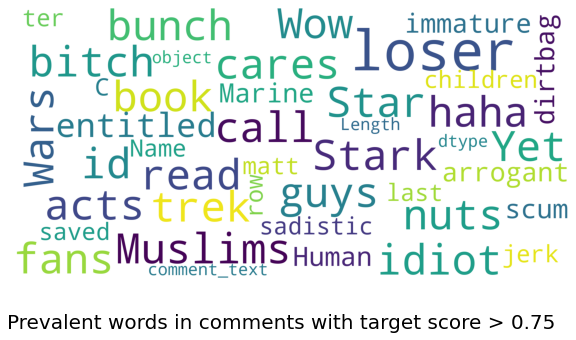

In [32]:
show_wordcloud(train_df.loc[train_df['target'] > 0.75]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.75')

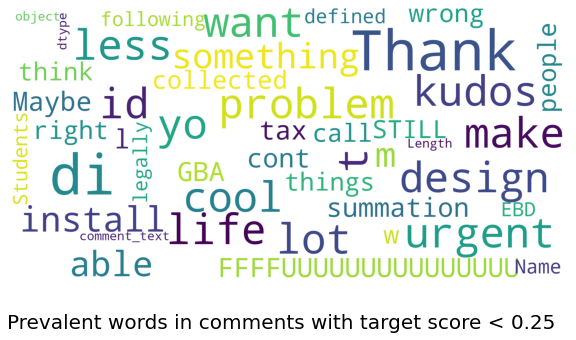

In [33]:
show_wordcloud(train_df.loc[train_df['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

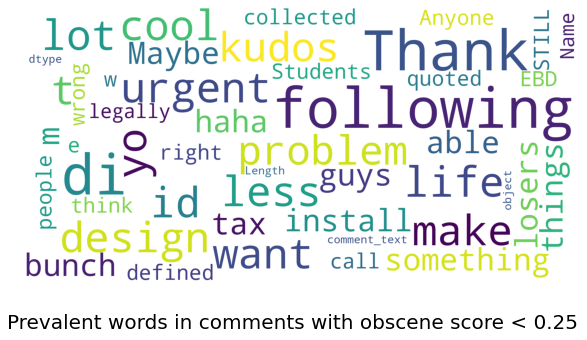

In [34]:
show_wordcloud(train_df.loc[train_df['obscene']< 0.25]['comment_text'], 
               title = 'Prevalent words in comments with obscene score < 0.25')

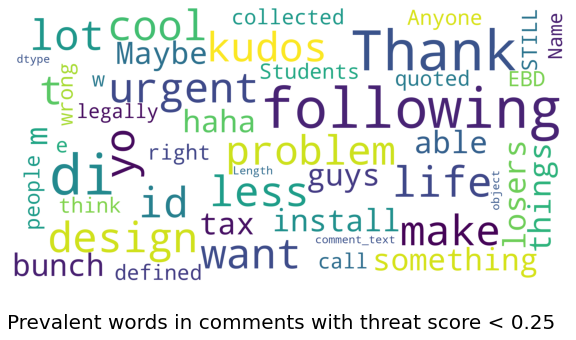

In [35]:
show_wordcloud(train_df.loc[train_df['threat'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with threat score < 0.25')

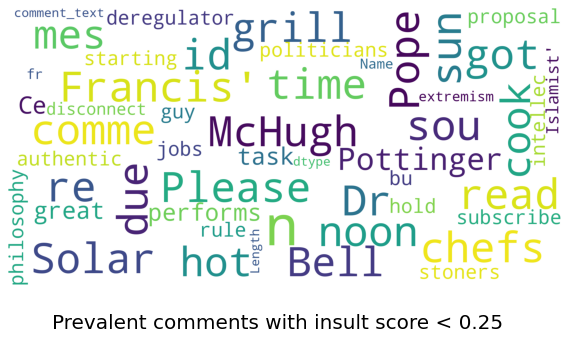

In [36]:
show_wordcloud(train_df.loc[train_df['insult'] < 0.25]['comment_text'].sample(20000), 
               title = 'Prevalent comments with insult score < 0.25')

# Text Preprocessing:

# Splitting the data into train and test:

In [37]:
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
def preprocess(text_string):
    text_string = text_string.lower() # Convert everything to lower case.
    text_string = re.sub('[^A-Za-z0-9]+', ' ', text_string) # Remove special characters and punctuations
    
    x = text_string.split()
    new_text = []
    
    for word in x:
        if word not in stop_words:
            new_text.append(stemmer.stem(word))
            
    text_string = ' '.join(new_text)
    return text_string

In [38]:
%%time
train_df['preprocessed_text'] = train_df['comment_text'].apply(preprocess)

Wall time: 13min 21s


In [39]:
train_df.head()

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,preprocessed_text
id,,,,,,,,,,,,,,,,,,,,,
59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,cool like would want mother read realli great ...
59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,thank would make life lot less anxieti induc k...
59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,urgent design problem kudo take impress
59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,someth abl instal site releas
59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,...,rejected,0,0,0,1,0,0.0,4,47,haha guy bunch loser


In [40]:
%%time
test_df['preprocessed_text'] = test_df['comment_text'].apply(preprocess)

Wall time: 38.6 s


In [41]:
feature = train_df[['preprocessed_text']]
output = train_df[['target']]
X_train, X_cv, y_train, y_cv = train_test_split(feature, output)

print(X_train.shape)
print(X_cv.shape)
print(y_train.shape)
print(y_cv.shape)

(1353655, 1)
(451219, 1)
(1353655, 1)
(451219, 1)


In [42]:
X_train.head()

,preprocessed_text
id,
5954120,next thing propos vancouv london uk start impo...
931504,unless english teacher quit day job
1042859,danish man burn qur self defenc prosecut blasp...
5143142,let pretend stand line vote best way encourag ...
6255663,miss point whether charg sexual assault procee...


In [43]:
X_cv.head()

,preprocessed_text
id,
5802035,light hermann goer honor man eloqu explain peo...
5671105,agre communiti garden small scale farm mayb aq...
520299,okay shut certain fishermen oh wait next chop ...
5148311,fortun peopl work live senat pass incom tax ho...
5898737,doubt truth one write code navi like illeg ali...


In [44]:
X_test = test_df[['preprocessed_text']]
X_test.head()

,preprocessed_text
id,
7097320,integr mean pay debt appli presid trump
7097321,malfeas administr board wast money
7097322,rmiller101 spoken like true elitist look bud a...
7097323,paul thank kind word inde strong belief hide b...
7097324,sorri miss high school eisenhow sent troop vie...


In [45]:
# Saving the files to csv so that we dont need to preprocess again.
X_train.to_pickle('X_train.pkl')
X_cv.to_pickle('X_cv.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_cv.to_pickle('y_cv.pkl')

# Training The Models:

In [46]:
# To load the csv files:
# Uncomment the block.
X_train = pd.read_pickle('X_train.pkl')
X_cv = pd.read_pickle('X_cv.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_cv = pd.read_pickle('y_cv.pkl')

# 1. Bag of Words (BoW):

Bag of words for converting text to vecters

In [47]:
cnt_vec = CountVectorizer(ngram_range=(1,2), max_features=30000)
bow_train = cnt_vec.fit_transform(X_train['preprocessed_text'])
bow_cv = cnt_vec.transform(X_cv['preprocessed_text'])
bow_test = cnt_vec.transform(X_test['preprocessed_text'])

print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


# 1.1 SGDRegressor:
1.1.1 Hyperparameter Tuning:

In [48]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.3822791856154765
Mean Squared Error on cv set:  0.0506793818250162
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  1.9036131278725967
Mean Squared Error on cv set:  0.13789487090006486
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.024518603020432093
Mean Squared Error on cv set:  0.024363881494572037
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.4375448313928285
Mean Squared Error on cv set:  0.04847558738092014
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03152457398060109
Mean Squared Error on cv set:  0.031249879557008167
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.13480316513840834
Mean Squared Error on cv set:  0.053828996132369814
***********************************************

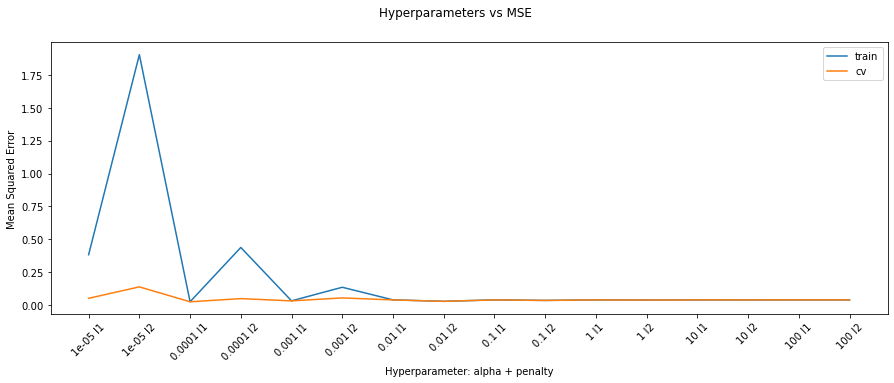

In [49]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

In [50]:
# Getting the best model parameters:
best_model.get_params()

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'penalty': 'l1',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

# 1.1.2 Feature Importance:

In [51]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = cnt_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
idiot,0.430326
stupid,0.337118
moron,0.295604
pathet,0.290026
crap,0.273794
hypocrit,0.264745
dumb,0.254245
ass,0.232141
clown,0.231062
damn,0.214484


In [52]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.012856
agre,-0.012524
white hous,-0.012261
great,-0.010346
com,-0.009817
may,-0.009769
new,-0.009609
http,-0.009507
interest,-0.009308
number,-0.008979


# 1.2 Decision Trees:

# 1.2.1 Hyperparameter Tuning:

In [53]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(bow_train, y_train) # Train
        
        preds = model.predict(bow_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(bow_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03318436869064789
Mean Squared Error on cv set:  0.032871594238914045
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03318436869064789
Mean Squared Error on cv set:  0.032871594238914045
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03318630453874954
Mean Squared Error on cv set:  0.03287397855770897
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03210856878494828
Mean Squared Error on cv set:  0.031795917830787265
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03211158461996895
Mean Squared Error on cv set:  0.0317990165204778
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on trai

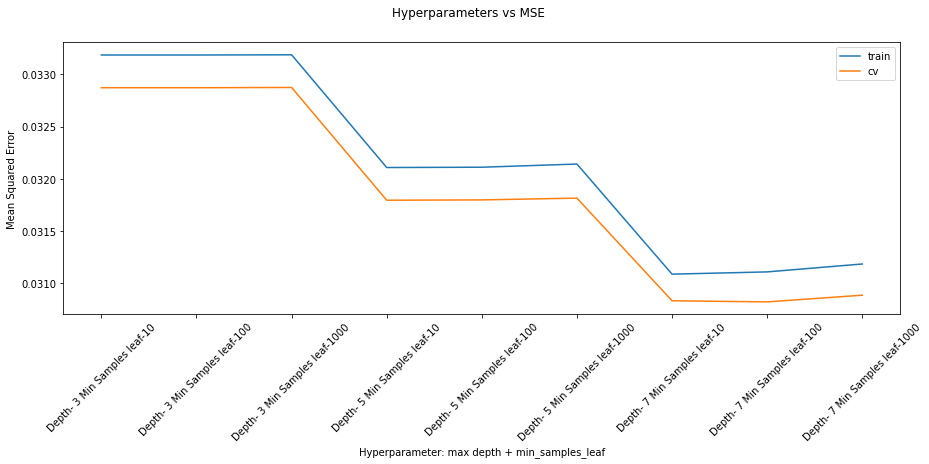

In [54]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

In [55]:
# Best models parameters:
best_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 100,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

# 1.2.2 Feature Importance:

In [56]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.394196
idiot,0.263671
pathet,0.070150
fool,0.068041
moron,0.062725
white,0.059967
hypocrit,0.056069
racist,0.005791
one,0.003849
would,0.003709


# 2. Term Frequency - Inverse Document Frequency (TFIDF) :

In [57]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
tfidf_train = tfidf_vec.fit_transform(X_train['preprocessed_text'])
tfidf_cv = tfidf_vec.transform(X_cv['preprocessed_text'])
tfidf_test = tfidf_vec.transform(X_test['preprocessed_text'])

print(tfidf_train.shape)
print(tfidf_cv.shape)
print(tfidf_test.shape)

(1353655, 30000)
(451219, 30000)
(97320, 30000)


# 2.1 SGDRegressor:

# 2.1.1 Hyperparameter Tuning:

In [58]:
# Performing hyperparameter tuning:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
penalty = ['l1', 'l2']
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for a in alpha:
    for p in penalty:
        xticks.append(str(a) + ' ' + p)
        print(str(a) + ' ' + p + " :")
        
        model = SGDRegressor(alpha=a, penalty=p) 
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

1e-05 l1 :
Mean Squared Error on train set:  0.025274694402289178
Mean Squared Error on cv set:  0.025157852727991446
**************************************************
1e-05 l2 :
Mean Squared Error on train set:  0.023911848934324447
Mean Squared Error on cv set:  0.023870485497266503
**************************************************
0.0001 l1 :
Mean Squared Error on train set:  0.02976203780445263
Mean Squared Error on cv set:  0.02953518647585346
**************************************************
0.0001 l2 :
Mean Squared Error on train set:  0.025033579367802327
Mean Squared Error on cv set:  0.024956387060951907
**************************************************
0.001 l1 :
Mean Squared Error on train set:  0.03839570123591542
Mean Squared Error on cv set:  0.038138459555102935
**************************************************
0.001 l2 :
Mean Squared Error on train set:  0.030096372965543995
Mean Squared Error on cv set:  0.029925791939227175
**************************************

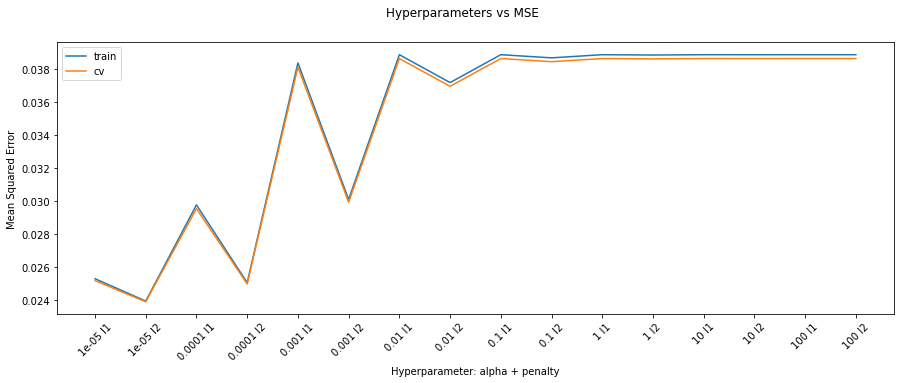

In [59]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(alpha) * len(penalty)), tr_errors)
plt.plot(range(len(alpha) * len(penalty)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(alpha) * len(penalty)), xticks, rotation=45)
plt.xlabel('Hyperparameter: alpha + penalty')
plt.ylabel('Mean Squared Error')
plt.show()

# 2.1.2 Feature Importance:

In [60]:
# Printing the 20 most important features/words which contribute to a comment being toxic.
feat_names = tfidf_vec.get_feature_names()
weights = best_model.coef_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,1.563769
idiot,1.265781
fool,0.660202
ignor,0.606551
dumb,0.603387
pathet,0.592358
moron,0.570926
ridicul,0.564339
loser,0.554496
liar,0.523163


In [61]:
# 20 most important features/words which contribute to comment being non-toxic.
df.sort_values("weights", ascending=True).iloc[0:20,:]

,weights
thank,-0.092523
interest,-0.086911
agre,-0.081195
stori,-0.080908
great,-0.073480
new,-0.069930
good,-0.069621
may,-0.069226
com,-0.068153
point,-0.067856


# 2.2 Decision Trees:

# 2.2.1 Hyperparameter Tuning:

In [62]:
# Performing hyperparameter tuning:
max_depth = [3, 5, 7]
min_samples = [10, 100, 1000]
xticks = []
tr_errors = []
cv_errors = []
best_model = None
best_error = 100
for d in max_depth:
    for samp in min_samples:
        xticks.append("Depth- " + str(d) + ' Min Samples leaf-' + str(samp))
        print("Depth- " + str(d) + ' Min Samples leaf-' + str(samp) + " :")
        
        model = DecisionTreeRegressor(max_depth=d, min_samples_leaf=samp)
        model.fit(tfidf_train, y_train) # Train
        
        preds = model.predict(tfidf_train) # Get predictions
        err = mean_squared_error(y_train['target'], preds) # Calculate error on trainset
        tr_errors.append(err)
        print("Mean Squared Error on train set: ", err)
        
        preds = model.predict(tfidf_cv) # Get predictions on CV set
        err = mean_squared_error(y_cv['target'], preds) # Calculate error on cv set
        cv_errors.append(err)
        print("Mean Squared Error on cv set: ", err)
        
        if err < best_error: # Get best model trained
            best_error = err
            best_model = model
        
        print("*"*50)

Depth- 3 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03298099473300248
Mean Squared Error on cv set:  0.03267062872921161
**************************************************
Depth- 3 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03298099473300249
Mean Squared Error on cv set:  0.0326706287292116
**************************************************
Depth- 3 Min Samples leaf-1000 :
Mean Squared Error on train set:  0.03298099473300248
Mean Squared Error on cv set:  0.032670628729211594
**************************************************
Depth- 5 Min Samples leaf-10 :
Mean Squared Error on train set:  0.03184738185922251
Mean Squared Error on cv set:  0.03152693861812235
**************************************************
Depth- 5 Min Samples leaf-100 :
Mean Squared Error on train set:  0.03184804883503463
Mean Squared Error on cv set:  0.03152589416432989
**************************************************
Depth- 5 Min Samples leaf-1000 :
Mean Squared Error on train 

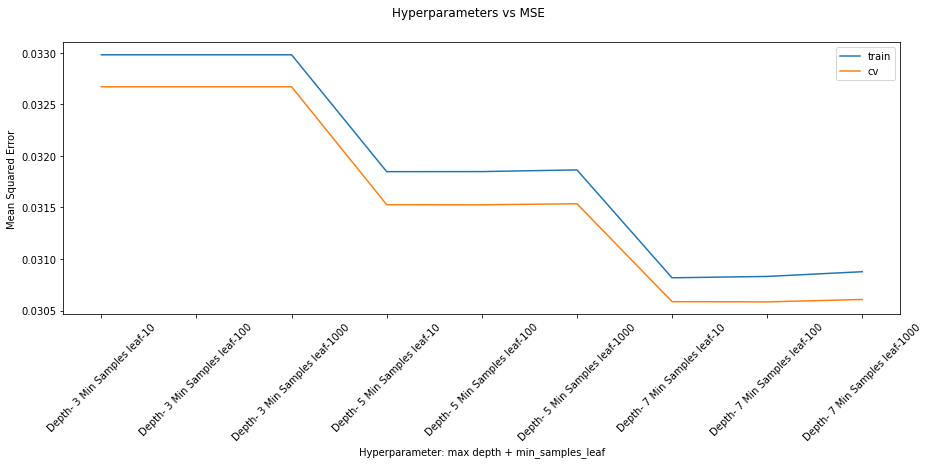

In [63]:
plt.figure(figsize=(15,5))
plt.suptitle("Hyperparameters vs MSE")
plt.plot(range(len(max_depth) * len(min_samples)), tr_errors)
plt.plot(range(len(max_depth) * len(min_samples)), cv_errors)
plt.legend(['train', 'cv'])
plt.xticks(range(len(max_depth) * len(min_samples)), xticks, rotation=45)
plt.xlabel('Hyperparameter: max depth + min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

# 2.2.2 Feature Importance:

In [64]:
weights = best_model.feature_importances_
df = pd.DataFrame(data=weights, columns=['weights'], index=feat_names)
df.sort_values("weights", ascending=False).iloc[0:20,:]

,weights
stupid,0.403784
idiot,0.267640
pathet,0.071991
fool,0.071836
moron,0.063380
white,0.058933
dumb,0.054633
racist,0.005492
trump,0.000871
peopl,0.000622


# 3. Features for LSTM:

In [65]:
class LSTMFeaturization:
    
    def __init__(self):
        self.word_mapping = None
        self.total_words = None
        
    
    # Accepts a list of sentences and builds a vocabulary.
    def build_vocabulary(self, sentences):
        
        vocab = set()
        for x in sentences:
            for word in x.split():
                vocab.add(word)
        
        # Create a dictionary from vocabulary.
        vocab_dict = dict.fromkeys(vocab, 0)
        
        # Calculate count of each word..
        for x in sentences:
            for word in x.split():
                vocab_dict[word]+=1
                
        return vocab_dict
    
    
    
    # Accepts a dictionary (vocabulary) and gets the word number in dictionary format
    def get_mapping(self, vocab_dict):
                
        # Get the number of each word into the corpus.
        k = []
        v = []
        for keys,val in vocab_dict.items():
            k.append(keys)
            v.append(val)
            
        kv = np.vstack((k,v)).T
        df = pd.DataFrame(columns=["Word","Count"], data=kv)
        df['Count'] = df['Count'].astype('int')
        
        # Sort the dataframe to get the largest count at first place
        df.sort_values(by=['Count'], ascending=False, inplace=True)
        
        # Give numbering to the most frequent word as 1 then next as 2 and so on.
        df.reset_index(inplace=True)
        df['mapping'] = df.index + 1
        
        df.drop(columns=['index'], inplace=True)
        df.drop(columns=['Count'], inplace=True)
        
        # Convert to dictionary for easier processing.
        dictionary = dict(zip(df['Word'], df['mapping']))
        
        return dictionary
    
    
    # Accepts a list of sentences and generates vocabulary and word mappings.
    def fit(self, sentences):
        v = self.build_vocabulary(sentences)
        self.word_mapping = self.get_mapping(v)
        self.total_words = len(self.word_mapping)
        
    # Converts the sentences to number mappings.
    def transform(self, sentences, pad_length = 350):
        
        whole = list() # Stores mapping for all sentences
        for x in sentences: # for each sentence in list of sentences.
            
            part = list()
            for word in x.split(): # for each word
                if word in self.word_mapping:
                    part.append(self.word_mapping[word]) # Append mapped number.
            whole.append(part) # Append sentence.
        
        # Append additional values to make lengths equal.
        whole = keras.preprocessing.sequence.pad_sequences(np.array(whole), maxlen=pad_length)
        
        return whole

In [66]:
lstmfeat = LSTMFeaturization()
lstmfeat.fit(X_train['preprocessed_text'])

In [67]:
lstm_train = lstmfeat.transform(X_train['preprocessed_text'])
lstm_test = lstmfeat.transform(X_test['preprocessed_text'])
lstm_cv = lstmfeat.transform(X_cv['preprocessed_text'])

In [68]:
print(lstm_train.shape)
print(lstm_cv.shape)
print(lstm_test.shape)

(1353655, 350)
(451219, 350)
(97320, 350)


In [69]:
np.save('lstm_train.npy', lstm_train)
np.save('lstm_cv.npy', lstm_cv)
np.save('lstm_test.npy', lstm_test)

In [70]:
# create the model
embedding_vecor_length = 100
total_words = lstmfeat.total_words
model = Sequential()
model.add(Embedding(total_words ,embedding_vecor_length, input_length=350))
model.add(CuDNNLSTM(128, return_sequences=True))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          20147700  
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 350, 128)          117760    
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 128)               132096    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 20,397,685
Trainable params: 20,397,685
Non-trainable params: 0
_________________________________________________________________
None


In [77]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [87]:
history = model.fit(lstm_train, y_train, nb_epoch=5,
                    batch_size=2048, validation_data=(lstm_cv, y_cv), verbose = 1, callbacks=callbacks_list)

Epoch 1/5


InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node sequential/cu_dnnlstm/CudnnRNNV2}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", is_training=true, seed2=0]
Registered devices: [CPU]
Registered kernels:
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_DOUBLE]

	 [[sequential/cu_dnnlstm/CudnnRNNV2]] [Op:__inference_train_function_2445]

In [80]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

NameError: name 'history' is not defined

<Figure size 576x432 with 0 Axes>